# Define functions

In [15]:
#additional functions
def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos
    
def tokenize(text, modulation):
    if modulation<2:
        tokens = re.split(r'\W+', text)
        stems = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers=abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation==0:
                        stems.append(lowers)
                    if modulation==1:
                        stems.append(porter.stem(lowers))
    else:
        sp_text=sp(text)
        stems = []
        lemmatized_text=[]
        for word in sp_text:
            lemmatized_text.append(word.lemma_)
        stems = [abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)]
    return " ".join(stems)


def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector

In [31]:
# Define pre posessing pipleines
def preprocess_text_data(corpus_data, mod, column):

    text_preproc = corpus_data[column].astype(str).progress_apply(lambda row: tokenize(row, mod))
    
    corpus_data[column] = text_preproc

    corpus_data.dropna(subset=[column], inplace=True)
    corpus_data.reset_index(drop=True, inplace=True)
    
    # Convert to string
    corpus_data[column] = corpus_data[column].astype(str)

    return corpus_data


# Load data

In [51]:
import pandas as pd
import re
from tqdm import tqdm
tqdm.pandas()
import numpy as np
from matplotlib import pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords

import spacy
sp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [27]:
#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

In [9]:
lyrics_df = pd.read_csv('../../data/top songs.csv')

In [14]:
lyrics_df 

,title,tag,artist,release year,views,features,lyrics
0,let it be,rock,the beatles,1970,1481859,{},"When I find myself in times of trouble, Mothe..."
1,your song,rock,elton john,1970,1323166,{},"It's a little bit funny, this feeling inside ..."
2,paranoid,rock,black sabbath,1970,508767,{},Finished with my woman 'Cause she couldn't ...
3,immigrant song,rock,led zeppelin,1970,494355,{},"​ (2, 3, 4) Ahh! Ahh! We come from the land ..."
4,have you ever seen the rain,rock,creedence clearwater revival,1970,468949,{},Someone told me long ago There's a calm befor...
...,...,...,...,...,...,...,...
191995,attention female perspective,pop,andie case,2017,34129,{},"I been runnin' 'round, runnin' 'round, runnin..."
191996,​nobody 😔,rap,shinigami,2017,34115,{​shinigami},Take me away from this path that I follow It'...
191997,my time,rap,wolves,2017,34114,{},I'm ready to play now Put me in the game now I...
191998,down in flames,pop,ella vos,2017,34113,{},Slippin' off the edge Out of phase Watchin' y...


# Clean song lyrics

In [13]:
# Remove text inside square brackets
lyrics_df['lyrics'] = lyrics_df['lyrics'].str.replace(r'\[.*?\]', '', regex=True)

# Replace \n with a space 
lyrics_df['lyrics'] = lyrics_df['lyrics'].str.replace('\n', ' ', regex=False)

In [ ]:
lyrics_df = preprocess_text_data(lyrics_df, mod = 2, column = 'lyrics')

In [44]:
lyrics_df = lyrics_df.dropna(subset=['lyrics'])
lyrics_df.to_csv('../../data/top songs processed.csv', index=False)

In [35]:
lyrics_df = pd.read_csv('../../data/top songs processed.csv')

# Futher processing

In [61]:
cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.01, max_df=0.99, stop_words='english')

cv.fit(lyrics_df.lyrics)
vectorized_text=cv.transform(lyrics_df.lyrics)
vectorized_text=vectorized_text.todense()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (191999, 1340)


In [62]:
term_frequencies = np.sum(vectorized_text, axis=0).A1

# Sort frequencies and get sorted indices
sorted_indices = np.argsort(term_frequencies)[::-1]
sorted_frequencies = term_frequencies[list(sorted_indices)]

# Generate Term IDs (1-based indexing for better readability)
term_ids = np.arange(1, len(sorted_frequencies) + 1)

# Find the maximum value in the sorted frequencies
max_term_frequency = np.max(sorted_frequencies)
print("Max term frequency is", max_term_frequency)

# Get the feature names from the count vectorizer
feature_names = cv.get_feature_names_out()

# Now use sorted_indices to get the top terms
top_indices = sorted_indices[:5]  # Get the indices for the top 5 terms
top_terms = feature_names[top_indices]  # Get the corresponding feature names

# Now print out the top terms with their frequencies
for term, freq in zip(top_terms, sorted_frequencies[:5]):
    print(f"Term: {term}, Frequency: {freq}")


Max term frequency is 400851
Term: like, Frequency: 400851
Term: know, Frequency: 398182
Term: love, Frequency: 357946
Term: oh, Frequency: 274673
Term: say, Frequency: 264440


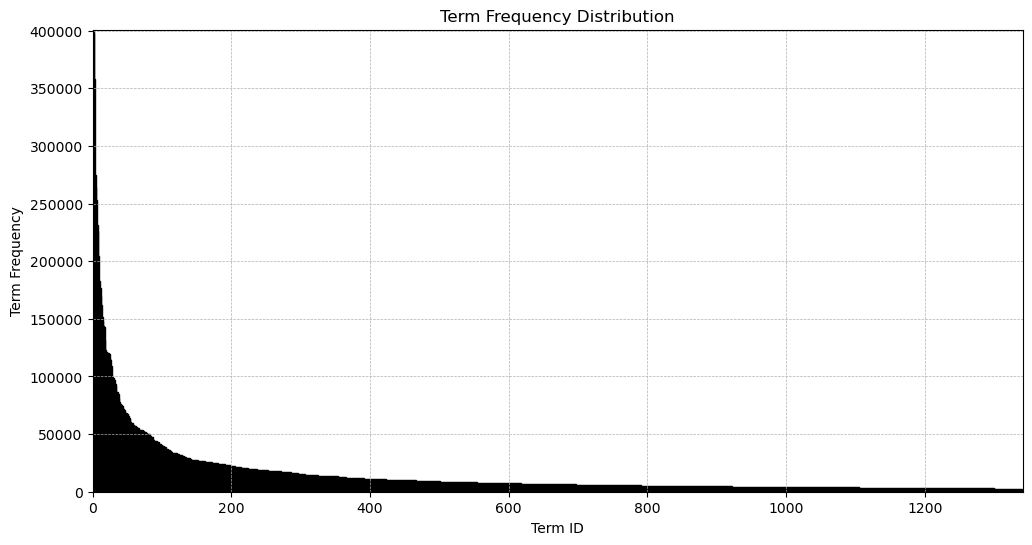

In [63]:
# Plotting with adjusted y-axis limits
plt.figure(figsize=(12, 6))
plt.bar(term_ids, sorted_frequencies, width=1.0, edgecolor='black')

# Set the y-axis and x-axis limits to start at 0 and end at the maximum
plt.ylim(0, max_term_frequency)
plt.xlim(left=0, right=len(term_ids)+1) 

# Improve the appearance
plt.title('Term Frequency Distribution')
plt.xlabel('Term ID')
plt.ylabel('Term Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.axhline(y=0, color='black', linewidth=1)

plt.show()

In [68]:
from sklearn.feature_extraction.text import TfidfTransformer

# Create the TfidfTransformer instance
tfidf_transformer = TfidfTransformer()

# Assuming 'vectorized_text' is the sparse matrix obtained from CountVectorizer
# Fit and transform the vectorized text data to get the TF-IDF representation
vectorized_text = np.asarray(vectorized_text)
tfidf_matrix = tfidf_transformer.fit_transform(vectorized_text)

# Now convert the sparse TF-IDF matrix to a dense numpy array
tfidf_matrix_dense = tfidf_matrix.toarray()

# Show the shape of the TF-IDF matrix
print("TF-IDF matrix has size", tfidf_matrix_dense.shape)

TF-IDF matrix has size (191999, 1340)


In [71]:
# Now you can see the words that match to each column
for i, feature in enumerate(feature_names):
    print(f"Column {i}: {feature}")

Column 0: 10
Column 1: 20
Column 2: 40
Column 3: 50
Column 4: act
Column 5: act like
Column 6: actin
Column 7: action
Column 8: add
Column 9: admit
Column 10: afraid
Column 11: age
Column 12: ago
Column 13: ah
Column 14: ahead
Column 15: ai
Column 16: aim
Column 17: air
Column 18: album
Column 19: alive
Column 20: alright
Column 21: america
Column 22: angel
Column 23: animal
Column 24: answer
Column 25: anybody
Column 26: anymore
Column 27: apart
Column 28: appear
Column 29: arm
Column 30: army
Column 31: art
Column 32: ask
Column 33: asleep
Column 34: ass
Column 35: attack
Column 36: attention
Column 37: awake
Column 38: away
Column 39: ay
Column 40: ayy
Column 41: babe
Column 42: baby
Column 43: baby baby
Column 44: baby come
Column 45: baby girl
Column 46: baby know
Column 47: baby let
Column 48: baby love
Column 49: baby oh
Column 50: bad
Column 51: bag
Column 52: ball
Column 53: band
Column 54: bang
Column 55: bank
Column 56: bar
Column 57: barely
Column 58: bass
Column 59: battle

In [72]:
lyrics_df

,title,tag,artist,release year,views,features,lyrics
0,let it be,rock,the beatles,1970,1481859,{},find time trouble mother mary come speak word ...
1,your song,rock,elton john,1970,1323166,{},little bit funny feeling inside one easily hid...
2,paranoid,rock,black sabbath,1970,508767,{},finish woman cause could help mind people thin...
3,immigrant song,rock,led zeppelin,1970,494355,{},2 3 4 ahh ahh come land ice snow midnight sun ...
4,have you ever seen the rain,rock,creedence clearwater revival,1970,468949,{},someone tell long ago calm storm know comin ti...
...,...,...,...,...,...,...,...
191995,attention female perspective,pop,andie case,2017,34129,{},runnin round runnin round runnin round throwin...
191996,​nobody 😔,rap,shinigami,2017,34115,{​shinigami},take away path follow leave hopeless empty hol...
191997,my time,rap,wolves,2017,34114,{},ready play put game come prove ready afraid pu...
191998,down in flames,pop,ella vos,2017,34113,{},slippin edge phase watchin pretend okay every ...


In [73]:
from sklearn.decomposition import LatentDirichletAllocation

# Assuming you already have your tfidf_matrix from earlier steps
lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(tfidf_matrix)

# Get the topic distribution for documents
topic_distributions = lda.transform(tfidf_matrix)



In [77]:
# Define the number of words to display per topic
n_top_words = 20

# Retrieve the topics and display them
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic #0:
rock roll rock roll play need know easy somebody fool time make say game love come like life want way people

Topic #1:
feel good like run feel like away time know make make feel life love run away alive come feel feel look feel good inside way

Topic #2:
ooh ooh ooh alright right right right shake oh yeah baby free ready sex love night know mmm woo body wanna ah

Topic #3:
want da want want tell know want know love tell tell know want oooh girl really say want love ay wanna need oh really want love want

Topic #4:
let dance let let hold tonight bye wanna come know tight hold tight love baby night oh let know want come let time say

Topic #5:
nigga bitch fuck niggas like shit know yeah money cause ass ya man make say yo wanna gon tell come

Topic #6:
like round say come eye look head red know make night man time ride hand white leave turn black oh

Topic #7:
like yo ya cause rhyme man shit know come make rap rock say yeah mic check uh mc time let

Topic #8:
dream eye love shi